In [1]:
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# please set the data path first
data_path = "data/creditcard_sample.csv"
data_df = pd.read_csv(data_path)
data_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,67374,-0.228866,0.086431,0.791165,-1.451021,1.141154,0.070110,0.442420,-0.128557,0.305720,...,0.162295,0.732803,-0.380588,-1.086826,0.376692,-0.481770,-0.077937,-0.220115,9.06,0
99995,67374,-1.336121,1.671947,0.994155,0.420318,-0.440923,-0.008386,-0.893860,-2.051884,-1.091297,...,-1.135695,0.509302,0.074188,0.266186,-0.117614,-0.515392,-0.049653,0.085873,2.50,0
99996,67374,0.662465,-1.336560,0.791566,0.425701,-1.391976,0.145471,-0.476652,0.203164,1.379204,...,-0.063744,-0.548785,-0.103769,0.136687,-0.078936,0.948579,-0.075607,0.053555,269.83,0
99997,67374,-4.930001,-1.090715,0.298037,1.890524,-1.058087,-0.329315,-1.498278,1.750301,-0.325311,...,0.051768,0.166222,-0.585006,0.219239,0.181934,-0.253197,0.113801,-1.043315,45.00,0


In [4]:
def train_test_split(data_set, train_ratio, seed):
    train_set_size = int(train_ratio * len(data_set))
    test_set_size = len(data_set) - train_set_size
    train_set, test_set = random_split(data_set, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(test_set)
def train_valid_split(data_set, train_ratio, seed):
    train_set_size = int(train_ratio * len(data_set))
    valid_set_size = len(data_set) - train_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)
def split_label(data_array):
    features = data_array[:, :-1]
    labels = data_array[:, -1]
    return features, labels

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed' : 1234,
    'train_ratio' : 0.8,
}
print("device : ", device)

device :  cpu


In [6]:
# fix seed
def same_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seed(config['seed'])

In [7]:
train_set, test_set = train_test_split(data_df.values, config['train_ratio'], config['seed'])
train_x, train_y = split_label(train_set)
test_x, test_y = split_label(test_set)
print(train_y.sum(), test_y.sum())

173.0 50.0



### Plotting

In [8]:
def plot_confusion_matrix(test_y, test_pred_class, model_type):
    print('\n')
    ax = sns.heatmap(confusion_matrix(test_y, test_pred_class), annot=True, cmap='Blues', fmt='d')

    ax.set_title(f'{model_type} Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');

    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    plt.show()

In [9]:
def plot_roc_curve(test_y, test_proba, model_type):
    ROC = roc_curve(test_y, test_proba[:,1])
    AUROC = auc(ROC[0], ROC[1])
    display = RocCurveDisplay(fpr=ROC[0], tpr=ROC[1], roc_auc=AUROC, estimator_name=model_type)
    display.plot()
    plt.title(f"ROC Curve of {model_type}")
    plt.show()

In [10]:
def plot_prc(test_y, test_proba, model_type):
    PRC = precision_recall_curve(test_y, test_proba[:,1])
    AUPRC = auc(PRC[1], PRC[0])    ## Warning : Need to invert the axis since X coordinates must be either monotonic increasing or monotonic decreasing. The auc will not change.
    display = PrecisionRecallDisplay(precision=PRC[0], recall=PRC[1], estimator_name=f'{model_type} (AUC = {AUPRC:.2f})')
    display.plot()
    plt.title(f"PR Curve of {model_type}")
    plt.show()

## Logisitic Regression

### Model

In [27]:
LR_Model = LogisticRegression(random_state=0)

### Training

In [28]:
LR_Model.fit(train_x, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

### Evaluation

In [29]:
LR_test_pred = LR_Model.predict(test_x)

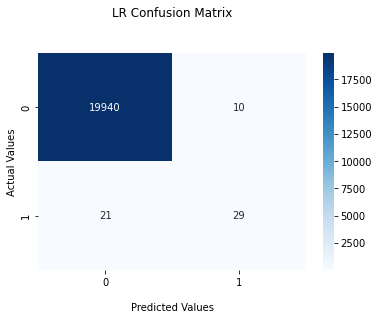

In [30]:
plot_confusion_matrix(test_y, LR_test_pred, "LR")

In [31]:
print("----------classification report of LR----------")
print(classification_report(test_y, LR_test_pred, labels=[0,1]))

----------classification report of LR----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       0.74      0.58      0.65        50

    accuracy                           1.00     20000
   macro avg       0.87      0.79      0.83     20000
weighted avg       1.00      1.00      1.00     20000



### ROC and PRC

In [32]:
LR_test_proba = LR_Model.predict_proba(test_x)

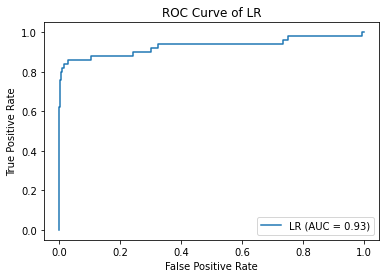

In [33]:
plot_roc_curve(test_y, LR_test_proba, "LR")

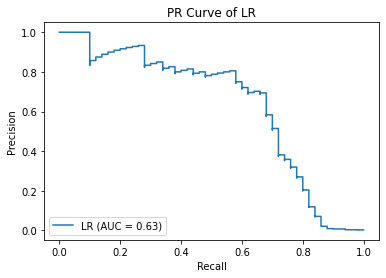

In [34]:
plot_prc(test_y, LR_test_proba, "LR")

## Support Vector Machine

### Model

In [35]:
SVM_Model = SVC(kernel='linear', probability=True)

### Training

In [36]:
SVM_Model.fit(train_x, train_y)

SVC(kernel='linear', probability=True)

### Evaluation



In [37]:
SVM_test_pred = SVM_Model.predict(test_x)

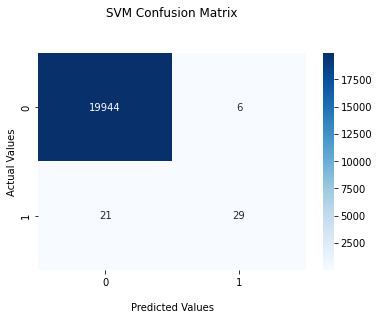

In [38]:
plot_confusion_matrix(test_y, SVM_test_pred, "SVM")

In [39]:
print("----------classification report of SVM----------")
print(classification_report(test_y, SVM_test_pred, labels=[0,1]))

----------classification report of SVM----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       0.83      0.58      0.68        50

    accuracy                           1.00     20000
   macro avg       0.91      0.79      0.84     20000
weighted avg       1.00      1.00      1.00     20000



### ROC and PRC

In [40]:
SVM_test_proba = SVM_Model.predict_proba(test_x)

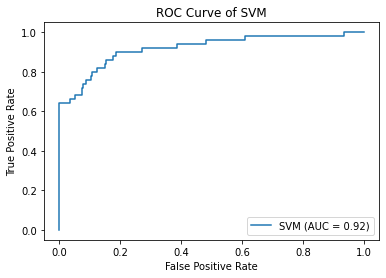

In [41]:
plot_roc_curve(test_y, SVM_test_proba, "SVM")

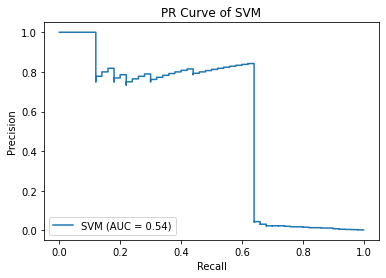

In [42]:
plot_prc(test_y, SVM_test_proba, "SVM")

## Random Forest

### Model

In [43]:
RF_Model = RandomForestClassifier(max_depth=5, random_state=0)

### Training

In [44]:
RF_Model.fit(train_x, train_y)

RandomForestClassifier(max_depth=5, random_state=0)

### Evaluation

In [45]:
RF_test_pred = RF_Model.predict(test_x)

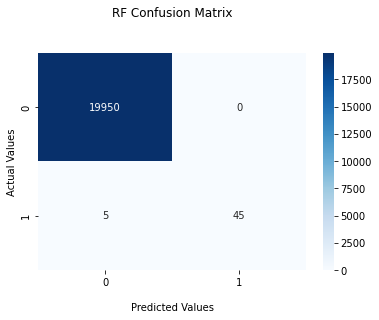

In [46]:
plot_confusion_matrix(test_y, RF_test_pred, "RF")

In [47]:
print("----------classification report of RF----------")
print(classification_report(test_y, RF_test_pred, labels=[0,1]))

----------classification report of RF----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       1.00      0.90      0.95        50

    accuracy                           1.00     20000
   macro avg       1.00      0.95      0.97     20000
weighted avg       1.00      1.00      1.00     20000



### ROC and PRC

In [48]:
RF_test_proba = RF_Model.predict_proba(test_x)

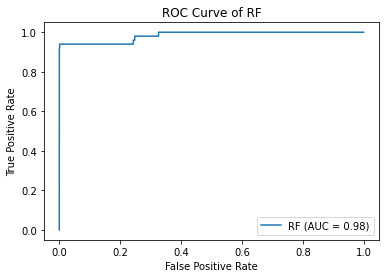

In [49]:
plot_roc_curve(test_y, RF_test_proba, "RF")

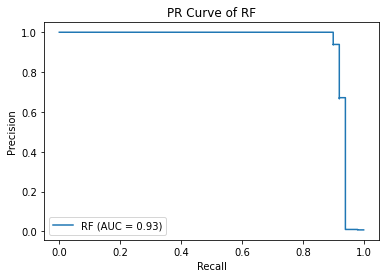

In [50]:
plot_prc(test_y, RF_test_proba, "RF")

## Deep Neural Network

for grid search：
1. number of hidden layers : 1,2,3
2. number of hidden units : 32,64,128
3. learning rate : 0.001, 0.003, 0.005
4. number of iterations : 10,50,100
5. mini-batch size : 256,512,1024



### Best config

In [11]:
config['batch_size'] = 256
config['n_epoch'] = 200
config['lr'] = 0.007
config['hidden_layers'] = 1
config['hidden_dim'] = 64
config["early_stop"] = 60

### Split train and valid

In [12]:
DNN_train_set, DNN_valid_set = train_valid_split(train_set, 0.9, config['seed'])
DNN_train_x, DNN_train_y = split_label(DNN_train_set)
DNN_valid_x, DNN_valid_y = split_label(DNN_valid_set)
train_y.sum(), DNN_train_y.sum(), DNN_valid_y.sum()

(173.0, 157.0, 16.0)

### Dataset

In [13]:
class Fraud_Dataset(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.Tensor(y)
            self.y_two_class = torch.Tensor([[0,1] if y==1 else [1,0] for y in y])
        self.x = torch.FloatTensor(x)
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx], self.y_two_class[idx]
    def __len__(self):
        return len(self.x)

### DataLoader

In [14]:
train_dataset = Fraud_Dataset(DNN_train_x, DNN_train_y)
valid_dataset = Fraud_Dataset(DNN_valid_x, DNN_valid_y)
test_dataset = Fraud_Dataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

### Model

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        x = self.block(x)
        return x


class DNN_Model(nn.Module):
    def __init__(self, hidden_layers=1, hidden_dim=64):
        super(DNN_Model, self).__init__()
        self.layers = nn.Sequential(
            BasicBlock(30, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim,2)
        )
        self.out_layer = nn.Sigmoid()

    def forward(self, x):
        y = self.layers(x)
        y = self.out_layer(y)
        return y

### Training

In [21]:
dnn_model = DNN_Model(hidden_layers=config['hidden_layers'], hidden_dim=config['hidden_dim']).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=config['lr'])

if not os.path.isdir('./models'):
    os.mkdir('./models')

model_path = "./models/dnn_model.ckpt"

dnn_model.train()
train_loss_list, train_acc_list = [], []
valid_loss_list, valid_acc_list = [], []
n_epoch = config['n_epoch']
best_acc, early_stop_count = 0, 0
for epoch in range(n_epoch):
    train_loss, train_acc = 0, 0
    valid_loss, valid_acc = 0, 0

    for x, y, y_two_class in train_loader:
        optimizer.zero_grad()
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = dnn_model(x)
        loss = criterion(outputs, y_two_class)
        loss.backward()
        optimizer.step()

        _, train_pred = torch.max(outputs, 1)
        train_loss += loss.detach().item()
        train_acc += (train_pred.cpu().detach() == y).sum().item()
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_dataset)

    with torch.no_grad():
        for x, y, y_two_class in valid_loader:
            x, y_two_class = x.to(device), y_two_class.to(device)
            outputs = dnn_model(x)
            loss = criterion(outputs, y_two_class)

            _, valid_pred = torch.max(outputs, 1)
            valid_loss += loss.detach().item()
            valid_acc += (valid_pred.cpu().detach() == y).sum().item()
        valid_loss = valid_loss/len(valid_loader)
        valid_acc = valid_acc/len(valid_dataset)

        if valid_acc > best_acc:
            best_acc = valid_acc
            early_stop_count = 0
            torch.save(dnn_model.state_dict(), model_path)
            print(f"Save model at epoch {epoch+1} with valid acc = {valid_acc}")
            print(f"train acc = {train_acc}, train_loss = {train_loss}")
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Acc : {train_acc} Loss : {train_loss} ; Valid Acc : {valid_acc} Loss : {valid_loss}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

Save model at epoch 1 with valid acc = 0.998
train acc = 0.9939999166655092, train_loss = 0.03558540199503488
Epoch [10/200] : Train Acc : 0.9978194141585299 Loss : 0.013333574723425909 ; Valid Acc : 0.998 Loss : 0.013211870922532398
Epoch [20/200] : Train Acc : 0.9978194141585299 Loss : 0.010608294717835408 ; Valid Acc : 0.998 Loss : 0.014013113843247993
Save model at epoch 24 with valid acc = 0.99825
train acc = 0.9981527521215573, train_loss = 0.00882515123676251
Save model at epoch 27 with valid acc = 0.998375
train acc = 0.9981388630397644, train_loss = 0.009672985928721812
Save model at epoch 28 with valid acc = 0.998625
train acc = 0.9984027555938277, train_loss = 0.009096788650532154
Epoch [30/200] : Train Acc : 0.9982916429394852 Loss : 0.010506287403734969 ; Valid Acc : 0.9985 Loss : 0.006643734075623797
Save model at epoch 31 with valid acc = 0.99875
train acc = 0.9982777538576925, train_loss = 0.008936775201792889
Save model at epoch 32 with valid acc = 0.998875
train acc =

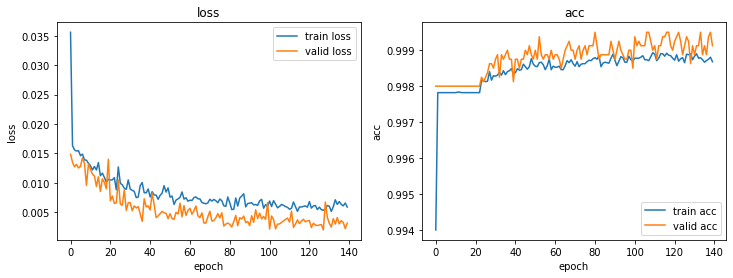

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(train_loss_list, label="train loss")
ax1.plot(valid_loss_list, label="valid loss")
ax1.legend()
ax2.set_title("acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(train_acc_list, label="train acc")
ax2.plot(valid_acc_list, label="valid acc")
ax2.legend()

### Evaluation



In [23]:
model = DNN_Model(hidden_layers=config['hidden_layers'], hidden_dim=config['hidden_dim']).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
DNN_test_proba, DNN_test_pred = [], []
test_loss, test_acc = 0, 0
with torch.no_grad():
    for x, y, y_two_class in tqdm(test_loader):
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = model(x)
        loss = criterion(outputs, y_two_class)
        DNN_test_proba += outputs.cpu().detach().tolist()

        _, test_pred = torch.max(outputs, 1)
        test_loss += loss.detach().item()
        test_acc += (test_pred.cpu().detach() == y).sum().item()
        DNN_test_pred += test_pred.tolist()
    test_acc = test_acc/len(test_dataset)
    test_loss = test_loss/len(test_loader)

100%|██████████| 79/79 [00:00<00:00, 431.46it/s]


In [24]:
print("train acc : ", round(train_acc,4))
print("test acc : ", round(test_acc,4))
print("train loss : ", round(train_loss,5))
print("test loss : ", round(test_loss,5))

train acc :  0.9989
test acc :  0.9991
train loss :  0.006
test loss :  0.00351


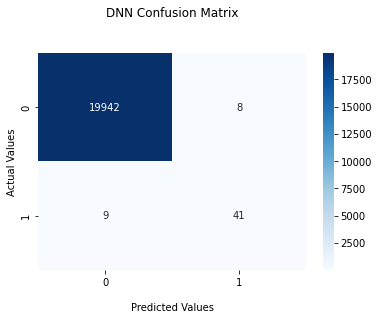

In [25]:
plot_confusion_matrix(test_y, DNN_test_pred, "DNN")

In [26]:
print("----------classification report of DNN----------")
print(classification_report(test_y, DNN_test_pred, labels=[0,1]))

----------classification report of DNN----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       0.84      0.82      0.83        50

    accuracy                           1.00     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       1.00      1.00      1.00     20000



### ROC and PRC

In [74]:
DNN_test_proba = np.array(DNN_test_proba)

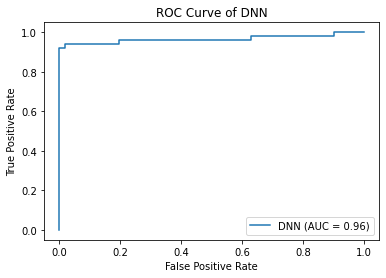

In [75]:
plot_roc_curve(test_y, np.array(DNN_test_proba), "DNN")

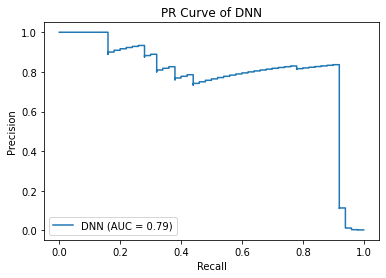

In [76]:
plot_prc(test_y, DNN_test_proba, "DNN")

# Random Undersampling

In [77]:
import random
random.seed(1)

In [78]:
fraud_num = int(sum(train_y))
non_fraud_index = []
for id in range(len(train_y)):
    if train_y[id] == 0:
        non_fraud_index.append(id)
sample_index = random.sample(non_fraud_index, fraud_num)

new_train_x, new_train_y, new_train_set = [], [], []
for id in range(len(train_y)):
    if train_y[id] == 1 or id in sample_index:
        new_train_x.append(train_x[id].tolist())
        new_train_y.append(train_y[id].tolist())
        new_train_set.append(train_set[id].tolist())
new_train_x = np.array(new_train_x)
new_train_y = np.array(new_train_y)
new_train_set = np.array(new_train_set)

## LR

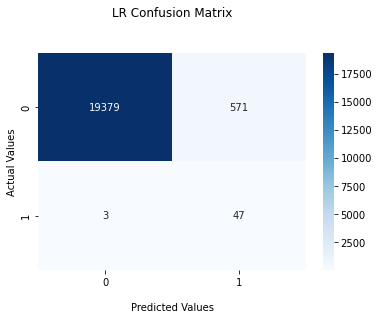

----------classification report of LR----------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19950
           1       0.08      0.94      0.14        50

    accuracy                           0.97     20000
   macro avg       0.54      0.96      0.56     20000
weighted avg       1.00      0.97      0.98     20000



In [81]:
LR_Model_2 = LogisticRegression(random_state=0)
LR_Model_2.fit(new_train_x, new_train_y)
LR_test_pred_2 = LR_Model_2.predict(test_x)
plot_confusion_matrix(test_y, LR_test_pred_2, "LR")
print("----------classification report of LR----------")
print(classification_report(test_y, LR_test_pred_2, labels=[0,1]))

## SVM

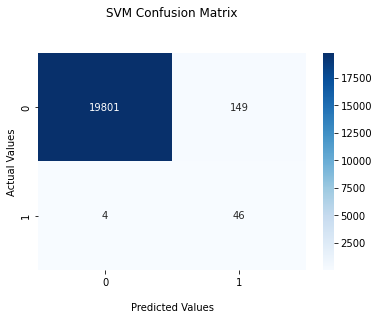

----------classification report of SVM----------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19950
           1       0.24      0.92      0.38        50

    accuracy                           0.99     20000
   macro avg       0.62      0.96      0.69     20000
weighted avg       1.00      0.99      0.99     20000



In [82]:
SVM_Model_2 = SVC(kernel='linear')
SVM_Model_2.fit(new_train_x, new_train_y)
SVM_test_pred_2 = SVM_Model_2.predict(test_x)
plot_confusion_matrix(test_y, SVM_test_pred_2, "SVM")
print("----------classification report of SVM----------")
print(classification_report(test_y, SVM_test_pred_2, labels=[0,1]))

## RF

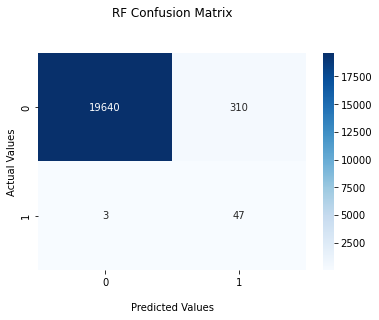

----------classification report of RF----------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19950
           1       0.13      0.94      0.23        50

    accuracy                           0.98     20000
   macro avg       0.57      0.96      0.61     20000
weighted avg       1.00      0.98      0.99     20000



In [83]:
RF_Model_2 = RandomForestClassifier(max_depth=5, random_state=0)
RF_Model_2.fit(new_train_x, new_train_y)
RF_test_pred_2 = RF_Model_2.predict(test_x)
plot_confusion_matrix(test_y, RF_test_pred_2, "RF")
print("----------classification report of RF----------")
print(classification_report(test_y, RF_test_pred_2, labels=[0,1]))

## DNN

In [114]:
config_2 = {
    'seed' : 1394,
    'batch_size' : 8,
    'n_epoch' : 1000,
    'lr' : 0.002,
    'hidden_layers' : 1,
    'hidden_dim' : 32,
    'early_stop' : 300,
    'test_batch_size' : 256
}

In [115]:
DNN_new_train_set, DNN_new_valid_set = train_valid_split(new_train_set, 0.9, config_2['seed'])
DNN_new_train_x, DNN_new_train_y = split_label(DNN_new_train_set)
DNN_new_valid_x, DNN_new_valid_y = split_label(DNN_new_valid_set)
new_train_y.sum(), DNN_new_train_y.sum(), DNN_new_valid_y.sum()

(173.0, 158.0, 15.0)

In [116]:
new_train_dataset = Fraud_Dataset(DNN_new_train_x, DNN_new_train_y)
new_valid_dataset = Fraud_Dataset(DNN_new_valid_x, DNN_new_valid_y)
test_dataset = Fraud_Dataset(test_x, test_y)

new_train_loader = DataLoader(new_train_dataset, batch_size=config_2['batch_size'], shuffle=True, pin_memory=True)
new_valid_loader = DataLoader(new_valid_dataset, batch_size=config_2['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config_2['test_batch_size'], shuffle=False, pin_memory=True)

In [117]:
dnn_model_2 = DNN_Model(hidden_layers=config_2['hidden_layers'], hidden_dim=config_2['hidden_dim']).to(device)
criterion_2 = nn.BCELoss()
optimizer_2 = torch.optim.Adam(dnn_model_2.parameters(), lr=config_2['lr'])

if not os.path.isdir('./models'):
    os.mkdir('./models')

model_path_2 = "./models/undersampling_dnn_model.ckpt"

dnn_model_2.train()
train_loss_list_2, train_acc_list_2 = [], []
valid_loss_list_2, valid_acc_list_2 = [], []
n_epoch = config_2['n_epoch']
best_acc, early_stop_count = 0, 0
for epoch in range(n_epoch):
    train_loss_2, train_acc_2 = 0, 0
    valid_loss_2, valid_acc_2 = 0, 0

    for x, y, y_two_class in new_train_loader:
        optimizer_2.zero_grad()
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = dnn_model_2(x)
        loss = criterion_2(outputs, y_two_class)
        loss.backward()
        optimizer_2.step()

        _, train_pred = torch.max(outputs, 1)
        train_loss_2 += loss.detach().item()
        train_acc_2 += (train_pred.cpu().detach() == y).sum().item()
    train_loss_2 = train_loss_2/len(new_train_loader)
    train_acc_2 = train_acc_2/len(new_train_dataset)

    with torch.no_grad():
        for x, y, y_two_class in new_valid_loader:
            x, y_two_class = x.to(device), y_two_class.to(device)
            outputs = dnn_model_2(x)
            loss = criterion_2(outputs, y_two_class)

            _, valid_pred = torch.max(outputs, 1)
            valid_loss_2 += loss.detach().item()
            valid_acc_2 += (valid_pred.cpu().detach() == y).sum().item()
        valid_loss_2 = valid_loss_2/len(new_valid_loader)
        valid_acc_2 = valid_acc_2/len(new_valid_dataset)

        if valid_acc_2 > best_acc:
            best_acc = valid_acc_2
            early_stop_count = 0
            torch.save(dnn_model_2.state_dict(), model_path_2)
            print(f"Save model at epoch {epoch+1} with valid acc = {valid_acc_2}")
            print(f"train acc = {train_acc_2}, train_loss = {train_loss_2}")
        else:
            early_stop_count += 1

        if early_stop_count >= config_2['early_stop']:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Acc : {train_acc_2} Loss : {train_loss_2} ; Valid Acc : {valid_acc_2} Loss : {valid_loss_2}')
    train_loss_list_2.append(train_loss_2)
    train_acc_list_2.append(train_acc_2)
    valid_loss_list_2.append(valid_loss_2)
    valid_acc_list_2.append(valid_acc_2)

Save model at epoch 1 with valid acc = 0.4857142857142857
train acc = 0.4983922829581994, train_loss = 0.7129489978154501
Save model at epoch 2 with valid acc = 0.6285714285714286
train acc = 0.5659163987138264, train_loss = 0.6837734381357828
Save model at epoch 6 with valid acc = 0.6571428571428571
train acc = 0.6205787781350482, train_loss = 0.6635100856805459
Save model at epoch 9 with valid acc = 0.7714285714285715
train acc = 0.6270096463022508, train_loss = 0.6431056230496137
Epoch [10/1000] : Train Acc : 0.7395498392282959 Loss : 0.5679259338440039 ; Valid Acc : 0.6571428571428571 Loss : 0.6140305519104003
Save model at epoch 16 with valid acc = 0.8285714285714286
train acc = 0.707395498392283, train_loss = 0.5719312444711343
Save model at epoch 17 with valid acc = 0.8857142857142857
train acc = 0.6945337620578779, train_loss = 0.5861264581863697
Epoch [20/1000] : Train Acc : 0.6913183279742765 Loss : 0.5986596238918793 ; Valid Acc : 0.7428571428571429 Loss : 0.5413318812847138

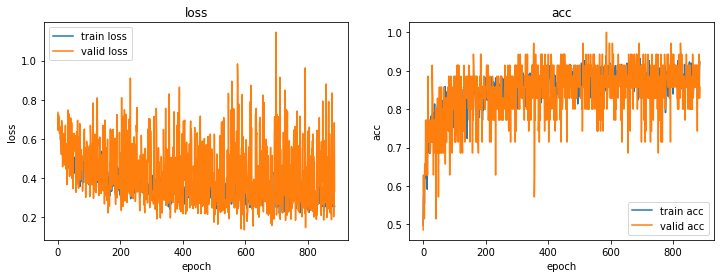

In [118]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(train_loss_list_2, label="train loss")
ax1.plot(valid_loss_list_2, label="valid loss")
ax1.legend()
ax2.set_title("acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(train_acc_list_2, label="train acc")
ax2.plot(valid_acc_list_2, label="valid acc")
ax2.legend()

In [119]:
model = DNN_Model(hidden_layers=config_2['hidden_layers'], hidden_dim=config_2['hidden_dim']).to(device)
model.load_state_dict(torch.load(model_path_2))
model.eval()
DNN_test_proba_2, DNN_test_pred_2 = [], []
test_loss_2, test_acc_2 = 0, 0
with torch.no_grad():
    for x, y, y_two_class in tqdm(test_loader):
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = model(x)
        loss = criterion_2(outputs, y_two_class)
        DNN_test_proba_2 += outputs.cpu().detach().tolist()

        _, test_pred = torch.max(outputs, 1)
        test_loss_2 += loss.detach().item()
        test_acc_2 += (test_pred.cpu().detach() == y).sum().item()
        DNN_test_pred_2 += test_pred.tolist()
    test_acc_2 = test_acc_2/len(test_dataset)
    test_loss_2 = test_loss_2/len(test_loader)

100%|██████████| 79/79 [00:00<00:00, 368.89it/s]


In [120]:
print("train acc : ", round(train_acc_2,4))
print("test acc : ", round(test_acc_2,4))
print("train loss : ", round(train_loss_2,5))
print("test loss : ", round(test_loss_2,5))

train acc :  0.926
test acc :  0.9402
train loss :  0.21748
test loss :  0.35504


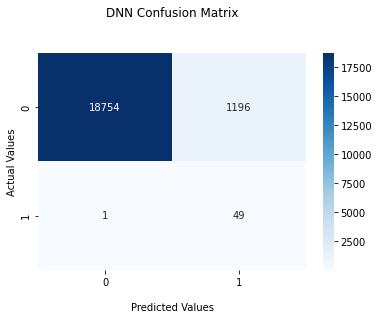

----------classification report of DNN----------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19950
           1       0.04      0.98      0.08        50

    accuracy                           0.94     20000
   macro avg       0.52      0.96      0.52     20000
weighted avg       1.00      0.94      0.97     20000



In [121]:
plot_confusion_matrix(test_y, DNN_test_pred_2, "DNN")
print("----------classification report of DNN----------")
print(classification_report(test_y, DNN_test_pred_2, labels=[0,1]))

# Bonus : SMOTETomek

In [12]:
from imblearn.combine import SMOTETomek

In [13]:
smt = SMOTETomek(random_state=50)
X_res, y_res = smt.fit_resample(train_x, train_y)
train_set_res = np.concatenate((X_res, y_res.reshape((len(y_res),1))),axis=1)

In [14]:
print("original total samples : " ,len(train_y))
print("original positive samples : " ,train_y.sum())
print("original positive sample ratio : ", train_y.sum()/len(train_y))
print("-----------------")
print("resampled total samples : " ,len(y_res))
print("resampled positive samples : " ,y_res.sum())
print("resampled positive sample ratio : ", y_res.sum()/len(y_res))

original total samples :  79999
original positive samples :  173.0
original positive sample ratio :  0.0021625270315878947
-----------------
resampled total samples :  159092
resampled positive samples :  79546.0
resampled positive sample ratio :  0.5


## LR

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


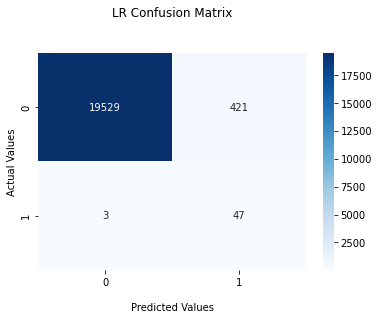

----------classification report of LR----------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19950
           1       0.10      0.94      0.18        50

    accuracy                           0.98     20000
   macro avg       0.55      0.96      0.59     20000
weighted avg       1.00      0.98      0.99     20000



In [16]:
LR_Model_3 = LogisticRegression(random_state=0)
LR_Model_3.fit(X_res, y_res)
LR_test_pred_3 = LR_Model_3.predict(test_x)
plot_confusion_matrix(test_y, LR_test_pred_3, "LR")
print("----------classification report of LR----------")
print(classification_report(test_y, LR_test_pred_3, labels=[0,1]))

## SVM

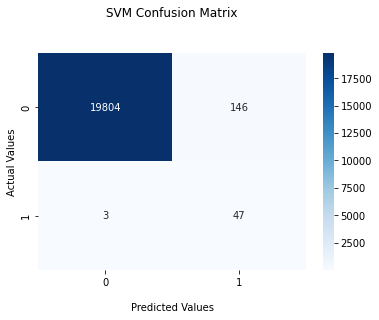

----------classification report of SVM----------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19950
           1       0.24      0.94      0.39        50

    accuracy                           0.99     20000
   macro avg       0.62      0.97      0.69     20000
weighted avg       1.00      0.99      0.99     20000



In [29]:
SVM_Model_3 = SVC(kernel='linear')
SVM_Model_3.fit(X_res, y_res)
SVM_test_pred_3 = SVM_Model_3.predict(test_x)
plot_confusion_matrix(test_y, SVM_test_pred_3, "SVM")
print("----------classification report of SVM----------")
print(classification_report(test_y, SVM_test_pred_3, labels=[0,1]))

## RF

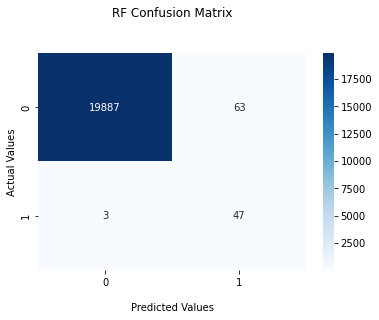

----------classification report of RF----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19950
           1       0.43      0.94      0.59        50

    accuracy                           1.00     20000
   macro avg       0.71      0.97      0.79     20000
weighted avg       1.00      1.00      1.00     20000



In [17]:
RF_Model_3 = RandomForestClassifier(max_depth=5, random_state=0)
RF_Model_3.fit(X_res, y_res)
RF_test_pred_3 = RF_Model_3.predict(test_x)
plot_confusion_matrix(test_y, RF_test_pred_3, "RF")
print("----------classification report of RF----------")
print(classification_report(test_y, RF_test_pred_3, labels=[0,1]))

## DNN

In [18]:
config_3 = {
    'seed' : 123,
    'batch_size' : 256,
    'n_epoch' : 100,
    'lr' : 0.005,
    'hidden_layers' : 1,
    'hidden_dim' : 32,
    'early_stop' : 100,
    'test_batch_size' : 256
}

In [19]:
DNN_train_set_res, DNN_valid_set_res = train_valid_split(train_set_res, 0.9, config_3['seed'])
DNN_train_x_res, DNN_train_y_res = split_label(DNN_train_set_res)
DNN_valid_x_res, DNN_valid_y_res = split_label(DNN_valid_set_res)
y_res.sum(), DNN_train_y_res.sum(), DNN_valid_y_res.sum()

(79546.0, 71600.0, 7946.0)

In [23]:
train_res_dataset = Fraud_Dataset(DNN_train_x_res, DNN_train_y_res)
valid_res_dataset = Fraud_Dataset(DNN_valid_x_res, DNN_valid_y_res)
test_dataset = Fraud_Dataset(test_x, test_y)

train_res_loader = DataLoader(train_res_dataset, batch_size=config_3['batch_size'], shuffle=True, pin_memory=True)
valid_res_loader = DataLoader(valid_res_dataset, batch_size=config_3['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config_3['test_batch_size'], shuffle=False, pin_memory=True)

In [24]:
dnn_model_3 = DNN_Model(hidden_layers=config_3['hidden_layers'], hidden_dim=config_3['hidden_dim']).to(device)
criterion_3 = nn.BCELoss()
optimizer_3 = torch.optim.Adam(dnn_model_3.parameters(), lr=config_3['lr'])

if not os.path.isdir('./models'):
    os.mkdir('./models')

model_path_3 = "./models/SMOTETomek_dnn_model.ckpt"

dnn_model_3.train()
train_loss_list_3, train_acc_list_3 = [], []
valid_loss_list_3, valid_acc_list_3 = [], []
n_epoch = config_3['n_epoch']
best_acc, early_stop_count = 0, 0
for epoch in range(n_epoch):
    train_loss_3, train_acc_3 = 0, 0
    valid_loss_3, valid_acc_3 = 0, 0

    for x, y, y_two_class in train_res_loader:
        optimizer_3.zero_grad()
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = dnn_model_3(x)
        loss = criterion_3(outputs, y_two_class)
        loss.backward()
        optimizer_3.step()

        _, train_pred = torch.max(outputs, 1)
        train_loss_3 += loss.detach().item()
        train_acc_3 += (train_pred.cpu().detach() == y).sum().item()
    train_loss_3 = train_loss_3/len(train_res_loader)
    train_acc_3 = train_acc_3/len(train_res_dataset)

    with torch.no_grad():
        for x, y, y_two_class in valid_res_loader:
            x, y_two_class = x.to(device), y_two_class.to(device)
            outputs = dnn_model_3(x)
            loss = criterion_3(outputs, y_two_class)

            _, valid_pred = torch.max(outputs, 1)
            valid_loss_3 += loss.detach().item()
            valid_acc_3 += (valid_pred.cpu().detach() == y).sum().item()
        valid_loss_3 = valid_loss_3/len(valid_res_loader)
        valid_acc_3 = valid_acc_3/len(valid_res_dataset)

        if valid_acc_3 > best_acc:
            best_acc = valid_acc_3
            early_stop_count = 0
            torch.save(dnn_model_3.state_dict(), model_path_3)
            print(f"Save model at epoch {epoch+1} with valid acc = {valid_acc_3}")
            print(f"train acc = {train_acc_3}, train_loss = {train_loss_3}")
        else:
            early_stop_count += 1

        if early_stop_count >= config_3['early_stop']:
            print(f'Model is not improving, early stop at epoch {epoch+1}.')
            break

    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{n_epoch}] : Train Acc : {train_acc_3} Loss : {train_loss_3} ; Valid Acc : {valid_acc_3} Loss : {valid_loss_3}')
    train_loss_list_3.append(train_loss_3)
    train_acc_list_3.append(train_acc_3)
    valid_loss_list_3.append(valid_loss_3)
    valid_acc_list_3.append(valid_acc_3)

Save model at epoch 1 with valid acc = 0.8884349465744814
train acc = 0.8551284379321423, train_loss = 0.31879317753815223
Save model at epoch 2 with valid acc = 0.9531741043368951
train acc = 0.9392172200416253, train_loss = 0.1719318955471473
Save model at epoch 3 with valid acc = 0.9606536769327467
train acc = 0.9521168862007794, train_loss = 0.14503471593904707
Save model at epoch 4 with valid acc = 0.963607793840352
train acc = 0.9567822771018704, train_loss = 0.13155245308631233
Save model at epoch 5 with valid acc = 0.9652419861722187
train acc = 0.9569149753460631, train_loss = 0.12602245771725262
Epoch [10/100] : Train Acc : 0.9664343283373609 Loss : 0.10322057871547129 ; Valid Acc : 0.9646134506599623 Loss : 0.1010859634668108
Save model at epoch 11 with valid acc = 0.9729101194217473
train acc = 0.9683270243466358, train_loss = 0.09733108832900013
Save model at epoch 17 with valid acc = 0.9754242614707731
train acc = 0.9700870221117179, train_loss = 0.09304946545578008
Epoch

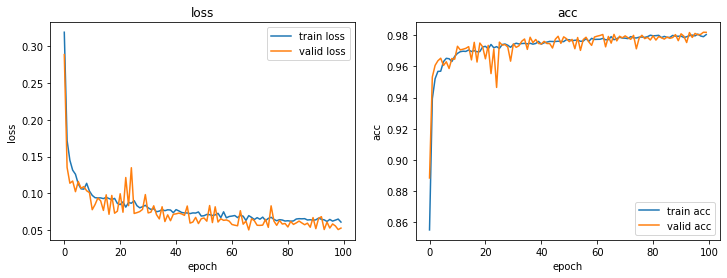

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title("loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.plot(train_loss_list_3, label="train loss")
ax1.plot(valid_loss_list_3, label="valid loss")
ax1.legend()
ax2.set_title("acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("acc")
ax2.plot(train_acc_list_3, label="train acc")
ax2.plot(valid_acc_list_3, label="valid acc")
ax2.legend()

In [26]:
model = DNN_Model(hidden_layers=config_3['hidden_layers'], hidden_dim=config_3['hidden_dim']).to(device)
model.load_state_dict(torch.load(model_path_3))
model.eval()
DNN_test_proba_3, DNN_test_pred_3 = [], []
test_loss_3, test_acc_3 = 0, 0
with torch.no_grad():
    for x, y, y_two_class in tqdm(test_loader):
        x, y_two_class = x.to(device), y_two_class.to(device)
        outputs = model(x)
        loss = criterion_3(outputs, y_two_class)
        DNN_test_proba_3 += outputs.cpu().detach().tolist()

        _, test_pred = torch.max(outputs, 1)
        test_loss_3 += loss.detach().item()
        test_acc_3 += (test_pred.cpu().detach() == y).sum().item()
        DNN_test_pred_3 += test_pred.tolist()
    test_acc_3 = test_acc_3/len(test_dataset)
    test_loss_3 = test_loss_3/len(test_loader)

100%|██████████| 79/79 [00:00<00:00, 359.87it/s]


In [27]:
print("train acc : ", round(train_acc_3,4))
print("test acc : ", round(test_acc_3,4))
print("train loss : ", round(train_loss_3,5))
print("test loss : ", round(test_loss_3,5))

train acc :  0.9804
test acc :  0.9932
train loss :  0.06109
test loss :  0.04918


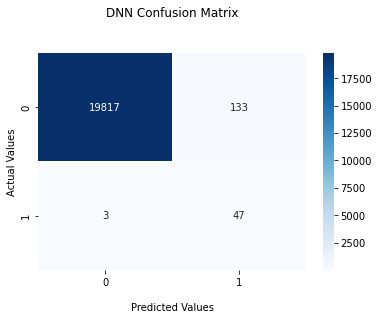

----------classification report of DNN----------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19950
           1       0.26      0.94      0.41        50

    accuracy                           0.99     20000
   macro avg       0.63      0.97      0.70     20000
weighted avg       1.00      0.99      1.00     20000



In [28]:
plot_confusion_matrix(test_y, DNN_test_pred_3, "DNN")
print("----------classification report of DNN----------")
print(classification_report(test_y, DNN_test_pred_3, labels=[0,1]))